# Predictive Maintenance – Engine Failure Classification (Final)

## Objective
Build a machine learning model to predict whether an engine requires maintenance
based on operational sensor data such as RPM, pressure, and temperature.

## Project structure
This project uses a **master folder** (the repository root) with a **data** subfolder for all datasets. Raw and processed data are stored under `data/` and the dataset is registered on the Hugging Face Dataset Hub for reproducibility.

## Import Libraries

In [1]:
! pip install -U huggingface_hub
! pip install -U pip
! pip install -U setuptools
! pip install -U "numpy<2.0"
! pip install -U "pandas<3.0"
! pip install -U matplotlib
! pip install -U seaborn
! pip install -U scikit-learn
! pip install ipywidgets
! pip install datasets
! pip install xgboost

In [2]:
from huggingface_hub import login, HfApi

login()

HfApi().whoami()

{'type': 'user',
 'id': '64ed56b294cee41a759346fd',
 'name': 'mukherjee78',
 'fullname': 'Siddhartha Mukherjee',
 'email': 'mukherjee.siddhartha@gmail.com',
 'emailVerified': True,
 'canPay': False,
 'billingMode': 'prepaid',
 'periodEnd': 1772323200,
 'isPro': False,
 'avatarUrl': '/avatars/bddea09c3e76a30cb281b043676d87cb.svg',
 'orgs': [{'type': 'org',
   'id': '64ed56ee94d56ab33665d00e',
   'name': 'mangoapps',
   'fullname': 'MangoApps Inc',
   'email': 'anup@mangoapps.com',
   'canPay': False,
   'billingMode': 'prepaid',
   'periodEnd': 1772323200,
   'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/64ed56b294cee41a759346fd/eN42VzXdfiuk6X073LsHF.png',
   'roleInOrg': 'admin',
   'isEnterprise': False},
  {'type': 'org',
   'id': '66862f795a5cdc0bae0145ac',
   'name': 'int2root',
   'fullname': 'Int2root LLP',
   'email': None,
   'canPay': False,
   'billingMode': 'postpaid',
   'periodEnd': None,
   'avatarUrl': 'https://www.gravatar.com/avatar/da668750197

## Data Registration

- A **master folder** (project/repository root) was created with a **data** subfolder to store all datasets (raw and processed).
- The dataset is **registered on the Hugging Face Dataset Hub** for versioning and reproducibility.
- **Dataset:** [mukherjee78/predictive-maintenance-engine-data](https://huggingface.co/datasets/mukherjee78/predictive-maintenance-engine-data)
- All data loading in this notebook uses this registered Hugging Face dataset.

In [3]:
from huggingface_hub import create_repo, upload_file, HfApi

dataset_repo_id = "mukherjee78/predictive-maintenance-engine-data"

api = HfApi()

create_repo(
    repo_id=dataset_repo_id,
    repo_type="dataset",
    private=False,
    exist_ok=True
)

upload_file(
    path_or_fileobj="../data/raw/engine_data.csv",
    path_in_repo="raw_data.csv",
    repo_id=dataset_repo_id,
    repo_type="dataset"
)

upload_file(
    path_or_fileobj="../data/raw/README.md",
    path_in_repo="README.md",
    repo_id=dataset_repo_id,
    repo_type="dataset"
)

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/mukherjee78/predictive-maintenance-engine-data/commit/06888d4a84a13d57b0469a2100c6fedee73cb24f', commit_message='Upload README.md with huggingface_hub', commit_description='', oid='06888d4a84a13d57b0469a2100c6fedee73cb24f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mukherjee78/predictive-maintenance-engine-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mukherjee78/predictive-maintenance-engine-data'), pr_revision=None, pr_num=None)

### Verify project structure (master folder and data subfolder)
The repository root is the master folder; below we confirm the `data` subfolder exists. Processed train/test files are saved under `data/processed/` later in this notebook.

In [4]:
from pathlib import Path

# Master folder = repo root; data subfolder must exist for saving train/test later
master = Path("..")
data_dir = master / "data"
print("Master folder (repo root) exists:", master.exists())
print("Data subfolder exists:", data_dir.exists())
if data_dir.exists():
    print("Contents of data/:", list(data_dir.iterdir()))

Master folder (repo root) exists: True
Data subfolder exists: True
Contents of data/: [PosixPath('../data/processed'), PosixPath('../data/raw')]


In [5]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Exploratory Data Analysis (EDA)

## Download Data From HuggingFace

In [6]:
from datasets import load_dataset

dataset = load_dataset(
    "mukherjee78/predictive-maintenance-engine-data",
    data_files="raw_data.csv"
)

df = dataset["train"].to_pandas()

df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


### Data collection and background
The data are multivariate sensor readings from industrial engines (RPM, pressures, temperatures). Each row is one observation; the target is **Engine Condition** (binary: normal vs. needs maintenance). The dataset is used for predictive maintenance so that failures can be anticipated from sensor patterns. It was loaded above directly from the registered Hugging Face dataset.

## Data Overview

This section provides a high-level overview of the dataset, including its dimensions, data types, missing values, and target variable distribution.

In [7]:
df.shape

(19535, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Engine rpm        19535 non-null  int64  
 1   Lub oil pressure  19535 non-null  float64
 2   Fuel pressure     19535 non-null  float64
 3   Coolant pressure  19535 non-null  float64
 4   lub oil temp      19535 non-null  float64
 5   Coolant temp      19535 non-null  float64
 6   Engine Condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine rpm,19535.0,791.239263,267.611193,61.000000,593.000000,746.000000,934.000000,2239.000000
Lub oil pressure,19535.0,3.303775,1.021643,0.003384,2.518815,3.162035,4.055272,7.265566
Fuel pressure,19535.0,6.655615,2.761021,0.003187,4.916886,6.201720,7.744973,21.138326
Coolant pressure,19535.0,2.335369,1.036382,0.002483,1.600466,2.166883,2.848840,7.478505
lub oil temp,19535.0,77.643420,3.110984,71.321974,75.725990,76.817350,78.071691,89.580796
Coolant temp,19535.0,78.427433,6.206749,61.673325,73.895421,78.346662,82.915411,195.527912
Engine Condition,19535.0,0.630509,0.482679,0.000000,0.000000,1.000000,1.000000,1.000000


### Column Name Standardization

The original dataset contained column names with spaces and inconsistent casing.
To improve code readability, reproducibility, and compatibility with machine
learning pipelines, all column names were standardized to snake_case format.

In [10]:
df.columns


Index(['Engine rpm', 'Lub oil pressure', 'Fuel pressure', 'Coolant pressure',
       'lub oil temp', 'Coolant temp', 'Engine Condition'],
      dtype='object')

In [11]:
def standardize_column_names(df):
    return df.columns.str.strip().str.lower().str.replace(" ", "_")
df.columns = standardize_column_names(df)

In [12]:
df.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19535 entries, 0 to 19534
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   engine_rpm        19535 non-null  int64  
 1   lub_oil_pressure  19535 non-null  float64
 2   fuel_pressure     19535 non-null  float64
 3   coolant_pressure  19535 non-null  float64
 4   lub_oil_temp      19535 non-null  float64
 5   coolant_temp      19535 non-null  float64
 6   engine_condition  19535 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 1.0 MB


In [14]:
df.isnull().sum()

engine_rpm          0
lub_oil_pressure    0
fuel_pressure       0
coolant_pressure    0
lub_oil_temp        0
coolant_temp        0
engine_condition    0
dtype: int64

# Target Variable Check

In [15]:
df["engine_condition"].value_counts()

engine_condition
1    12317
0     7218
Name: count, dtype: int64

In [16]:
df['engine_condition'].value_counts(normalize=True) * 100

engine_condition
1    63.050934
0    36.949066
Name: proportion, dtype: float64

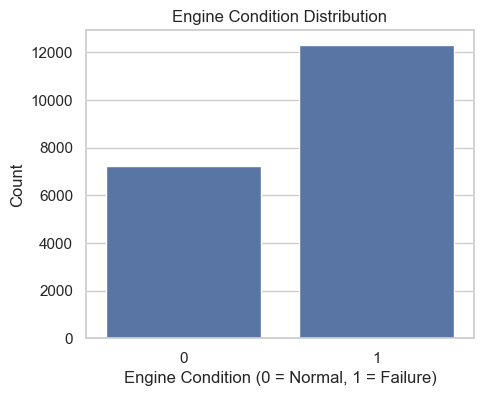

In [17]:
plt.figure(figsize=(5,4))
sns.countplot(x="engine_condition", data=df)
plt.title("Engine Condition Distribution")
plt.xlabel("Engine Condition (0 = Normal, 1 = Failure)")
plt.ylabel("Count")
plt.show()

### Data Summary Overview

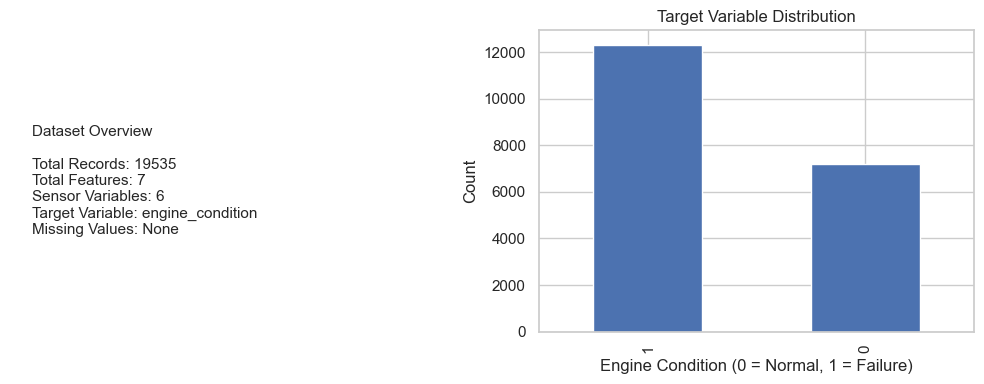

In [18]:
import matplotlib.pyplot as plt

# Dataset summary values
num_rows, num_cols = df.shape
num_sensors = len([
    'engine_rpm',
    'lub_oil_pressure',
    'fuel_pressure',
    'coolant_pressure',
    'lub_oil_temp',
    'coolant_temp'
])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# --- Left panel: Dataset summary text ---
axes[0].axis('off')
summary_text = (
    f"Dataset Overview\n\n"
    f"Total Records: {num_rows}\n"
    f"Total Features: {num_cols}\n"
    f"Sensor Variables: {num_sensors}\n"
    f"Target Variable: engine_condition\n"
    f"Missing Values: None"
)
axes[0].text(0.05, 0.5, summary_text, fontsize=11, verticalalignment='center')

# --- Right panel: Target distribution ---
df['engine_condition'].value_counts().plot(
    kind='bar',
    ax=axes[1]
)
axes[1].set_title("Target Variable Distribution")
axes[1].set_xlabel("Engine Condition (0 = Normal, 1 = Failure)")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.savefig("../reports/figures/data_overview_summary.png", dpi=300)
plt.show()

## Exploratory Data Analysis (EDA)

### 1. Univariate Analysis

This section analyzes the individual distribution of each engine sensor variable
to understand normal operating ranges, variability, and potential anomalies.

# Distribution of Engine RPM

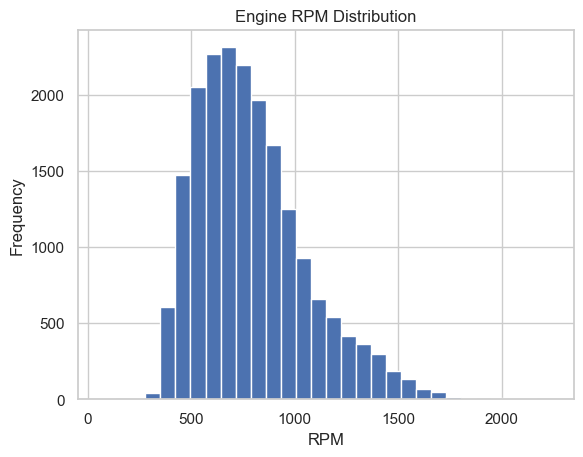

In [19]:
df["engine_rpm"].hist(bins=30)
plt.title("Engine RPM Distribution")
plt.xlabel("RPM")
plt.ylabel("Frequency")
plt.show()


# Outlier Detection

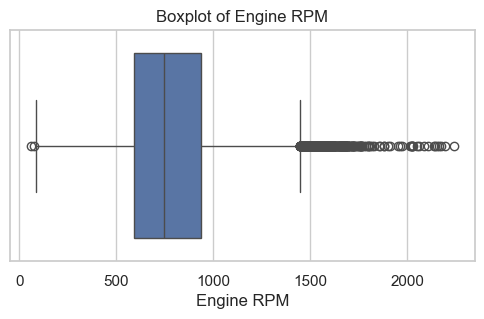

In [20]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["engine_rpm"])
plt.title("Boxplot of Engine RPM")
plt.xlabel("Engine RPM")
plt.show()

Observations
- Most engine RPM values lie between 500 and 900 RPM, which represents normal operating conditions.
- The distribution is right-skewed, showing fewer instances of very high RPM values.
- The boxplot highlights several high-RPM outliers, with some engines operating above 1500 RPM.
- A small number of very low RPM values are also observed.

Business Interpretation
- Engines running at high RPM for long periods experience higher mechanical and thermal stress, increasing the risk of wear and failure.
- The presence of high-RPM outliers indicates engines that may be operating under heavy load or abnormal conditions.
- Monitoring RPM patterns can help identify risky engine behavior early and support timely maintenance actions.
- Engine_RPM is therefore an important feature for predicting potential engine failures.



> Given its wide operating range and the presence of extreme values, Engine_RPM is likely to play a significant role in differentiating normal engine behavior from failure-prone operating conditions.

# Distribution of Lub Oil Pressure

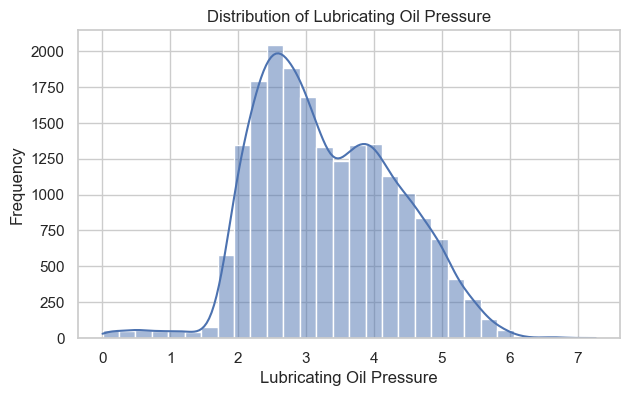

In [21]:
plt.figure(figsize=(7,4))
sns.histplot(df["lub_oil_pressure"], bins=30, kde=True)
plt.title("Distribution of Lubricating Oil Pressure")
plt.xlabel("Lubricating Oil Pressure")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection

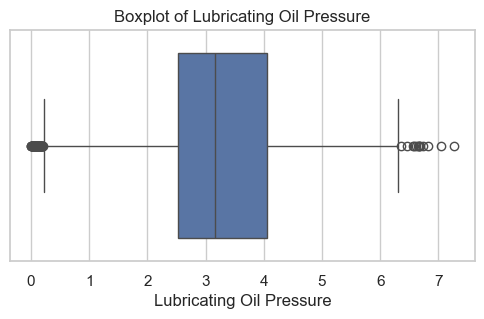

In [22]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["lub_oil_pressure"])
plt.title("Boxplot of Lubricating Oil Pressure")
plt.xlabel("Lubricating Oil Pressure")
plt.show()

Observations

- The lubricating oil pressure distribution is right-skewed, with the majority of observations concentrated between approximately 2.5 and 4.5 units, indicating a well-defined normal operating range.
- The distribution shows a dominant peak around 3 units, suggesting this value represents the most common and stable oil pressure during engine operation.
- A secondary rise in the density curve is visible between 4 and 5 units, indicating occasional operation at elevated oil pressure levels.
- The boxplot reveals the presence of both low-pressure and high-pressure outliers, with extreme values observed below 1 unit and above 6 units.
- The interquartile range indicates moderate variability, suggesting oil pressure is generally regulated but subject to deviations under certain operating conditions.


Business Interpretation

- Lubricating oil pressure is a critical engine health indicator, as it directly affects the lubrication of moving engine components.
- Low oil pressure outliers pose a significant risk, as insufficient lubrication can lead to increased friction, overheating, and accelerated mechanical wear, potentially resulting in severe engine damage or failure.
- High oil pressure anomalies may indicate blockages, restricted oil flow, or malfunctioning pressure regulation mechanisms, which can also compromise engine reliability.
- The presence of both low and high pressure extremes highlights the importance of continuous oil pressure monitoring as part of a predictive maintenance strategy.
- Given its strong mechanical relevance and observable variability, lubricating oil pressure is expected to be a key predictive feature in identifying engines at elevated risk of failure.


> Variations in lubricating oil pressure, particularly downward deviations, are likely to be strong predictors of engine failure and will play a key role in the predictive maintenance model.

# Distribution of Fuel Pressure

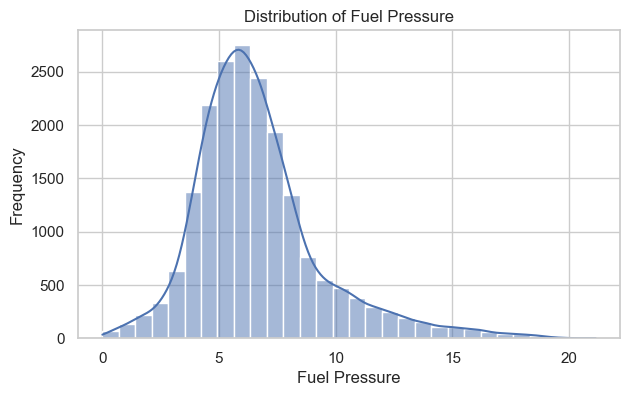

In [23]:
plt.figure(figsize=(7,4))
sns.histplot(df["fuel_pressure"], bins=30, kde=True)
plt.title("Distribution of Fuel Pressure")
plt.xlabel("Fuel Pressure")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection

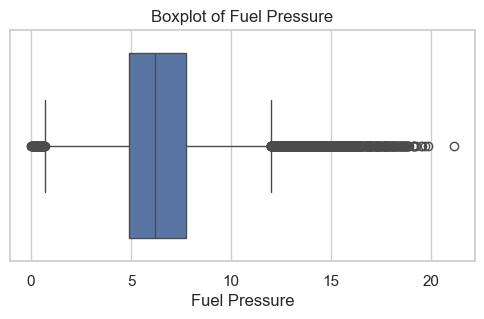

In [24]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["fuel_pressure"])
plt.title("Boxplot of Fuel Pressure")
plt.xlabel("Fuel Pressure")
plt.show()

Observations

- The fuel pressure distribution is right-skewed, with a pronounced peak between approximately 5 and 7 units, representing the normal operating range for most engines.
- The histogram shows a long right tail, with fuel pressure values extending beyond 15 units, indicating occasional operation at significantly elevated pressure levels.
- The majority of observations are tightly clustered around the central region, suggesting consistent fuel system performance under normal conditions.
- The boxplot highlights the presence of numerous high-end outliers, while low-pressure outliers are comparatively fewer.
- The interquartile range indicates moderate variability, with most engines operating within a controlled fuel pressure band.

Business Interpretation

- Fuel pressure directly affects air–fuel mixture quality, combustion efficiency, engine power output, and emissions.
- Excessively high fuel pressure may result from injector malfunctions, pressure regulator failures, or blockages in the return line, leading to inefficient combustion and increased fuel consumption.
- Low fuel pressure conditions, although less frequent, can cause fuel starvation, misfires, and reduced engine performance.
- The presence of a long right tail suggests that certain engines may be operating under stressful or abnormal fuel delivery conditions, increasing the risk of downstream engine issues.
- Continuous monitoring of fuel pressure enables early detection of fuel system anomalies, allowing preventive maintenance before combustion-related engine damage occurs.


> Given its wide operating range and the presence of extreme high-pressure values, fuel pressure is expected to be a meaningful predictor in identifying abnormal engine operating conditions associated with failure risk.

# Distribution of Coolant Pressure

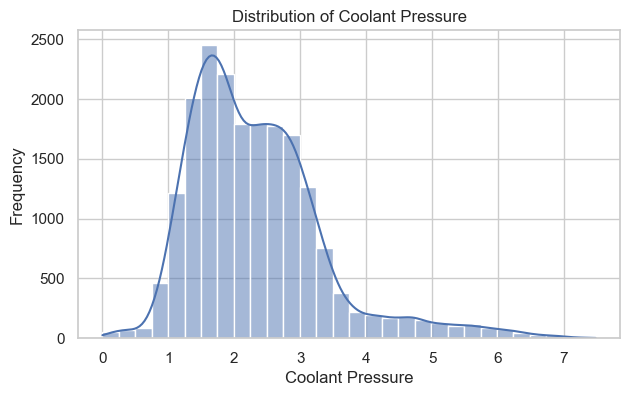

In [25]:
plt.figure(figsize=(7,4))
sns.histplot(df["coolant_pressure"], bins=30, kde=True)
plt.title("Distribution of Coolant Pressure")
plt.xlabel("Coolant Pressure")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection

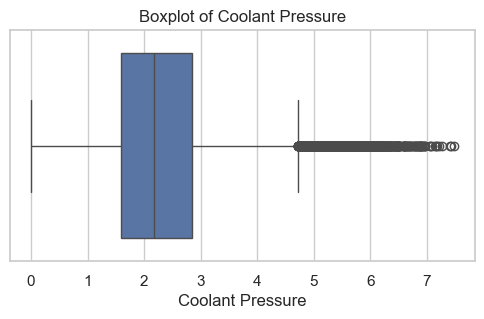

In [26]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["coolant_pressure"])
plt.title("Boxplot of Coolant Pressure")
plt.xlabel("Coolant Pressure")
plt.show()

Observations

- The coolant pressure distribution is right-skewed, with the majority of observations concentrated between approximately 1.5 and 3.0 units, representing the normal operating range.
- The histogram shows a dominant peak around 2 units, indicating a stable coolant pressure level for most engines.
- A long right tail is present, with coolant pressure values extending beyond 5 units, reflecting occasional high-pressure operating conditions.
- The boxplot reveals multiple high-pressure outliers, while very low coolant pressure values occur infrequently.
- The interquartile range is relatively narrow, suggesting that coolant pressure is generally well-regulated under normal engine operation.


Business Interpretation

- Coolant pressure is a key indicator of engine cooling system health, directly influencing heat dissipation and temperature control.
- Elevated coolant pressure outliers may indicate restricted coolant flow, radiator blockages, or excessive thermal expansion due to overheating, all of which increase the risk of engine damage.
- Although rare, low coolant pressure values can signal coolant leakage or pump inefficiencies, potentially leading to inadequate cooling.
- The presence of a long high-pressure tail highlights the need for continuous monitoring of coolant pressure to detect early signs of cooling system stress.
- Maintaining coolant pressure within its normal operating range is critical for preventing temperature-induced engine failures and extending engine lifespan.


> Given its direct relationship with engine temperature regulation, coolant pressure is expected to be an important feature in identifying engines exposed to overheating-related failure risks.

# Distribution of Lub Oil Temp

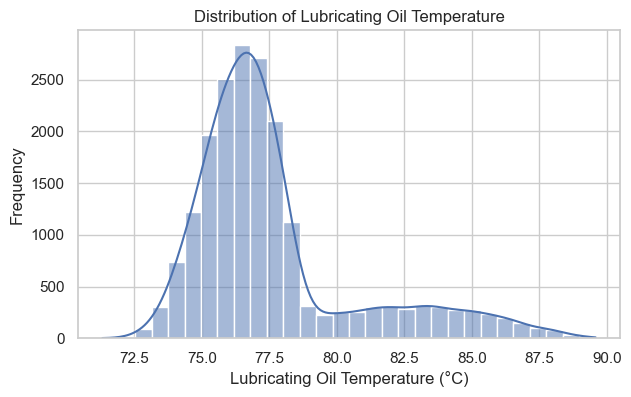

In [27]:
plt.figure(figsize=(7,4))
sns.histplot(df["lub_oil_temp"], bins=30, kde=True)
plt.title("Distribution of Lubricating Oil Temperature")
plt.xlabel("Lubricating Oil Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection

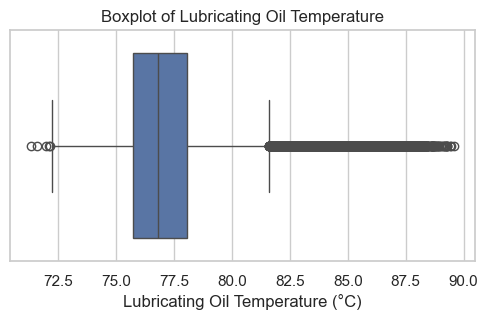

In [28]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["lub_oil_temp"])
plt.title("Boxplot of Lubricating Oil Temperature")
plt.xlabel("Lubricating Oil Temperature (°C)")
plt.show()

Observations

- The lubricating oil temperature distribution is right-skewed, with a dominant concentration of observations between approximately 74°C and 78°C, representing the normal operating temperature range.
- A clear and sharp peak is observed around 76°C, indicating stable oil temperature under typical engine operating conditions.
- The histogram reveals a distinct long right tail, with oil temperature values extending beyond 85°C and approaching 90°C, reflecting periods of elevated thermal stress.
- The boxplot highlights numerous high-temperature outliers, while low-temperature outliers are relatively infrequent.
- The interquartile range is narrow, suggesting that oil temperature is tightly controlled during normal operation, with deviations occurring primarily under stress conditions.


Business Interpretation

- Lubricating oil temperature is a critical determinant of lubrication effectiveness, as higher temperatures reduce oil viscosity and impair its ability to protect engine components.
- Elevated oil temperature outliers may indicate excessive engine load, insufficient cooling, friction due to wear, or early-stage mechanical degradation.
- Prolonged operation above the normal oil temperature range accelerates oil breakdown, increases component wear, and significantly raises the risk of engine failure.
- The pronounced right tail suggests that a subset of engines is regularly exposed to high thermal stress, making oil temperature a key variable for early failure detection.
- Monitoring oil temperature trends enables timely maintenance interventions, such as oil replacement or cooling system inspection, before irreversible damage occurs.

> Given its strong skewness and clear separation between normal and extreme values, lubricating oil temperature is expected to be one of the most influential predictors in the engine failure classification model.

# Distribution of Coolant Temperature

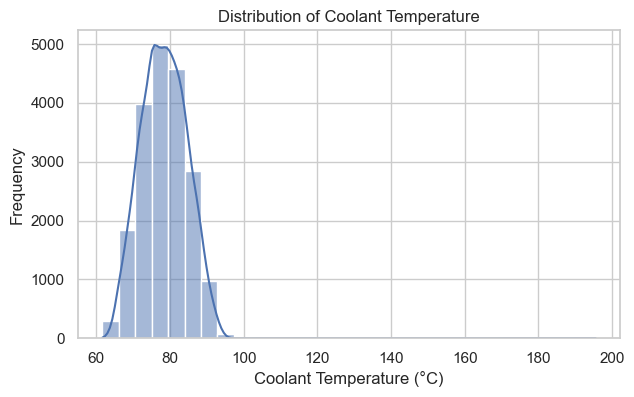

In [29]:
plt.figure(figsize=(7,4))
sns.histplot(df["coolant_temp"], bins=30, kde=True)
plt.title("Distribution of Coolant Temperature")
plt.xlabel("Coolant Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Outlier Detection

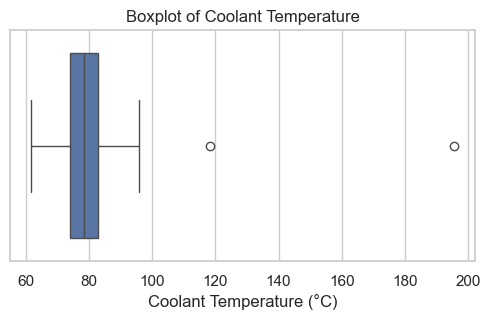

In [30]:
plt.figure(figsize=(6,3))
sns.boxplot(x=df["coolant_temp"])
plt.title("Boxplot of Coolant Temperature")
plt.xlabel("Coolant Temperature (°C)")
plt.show()

### Outliers of Sensor Variables

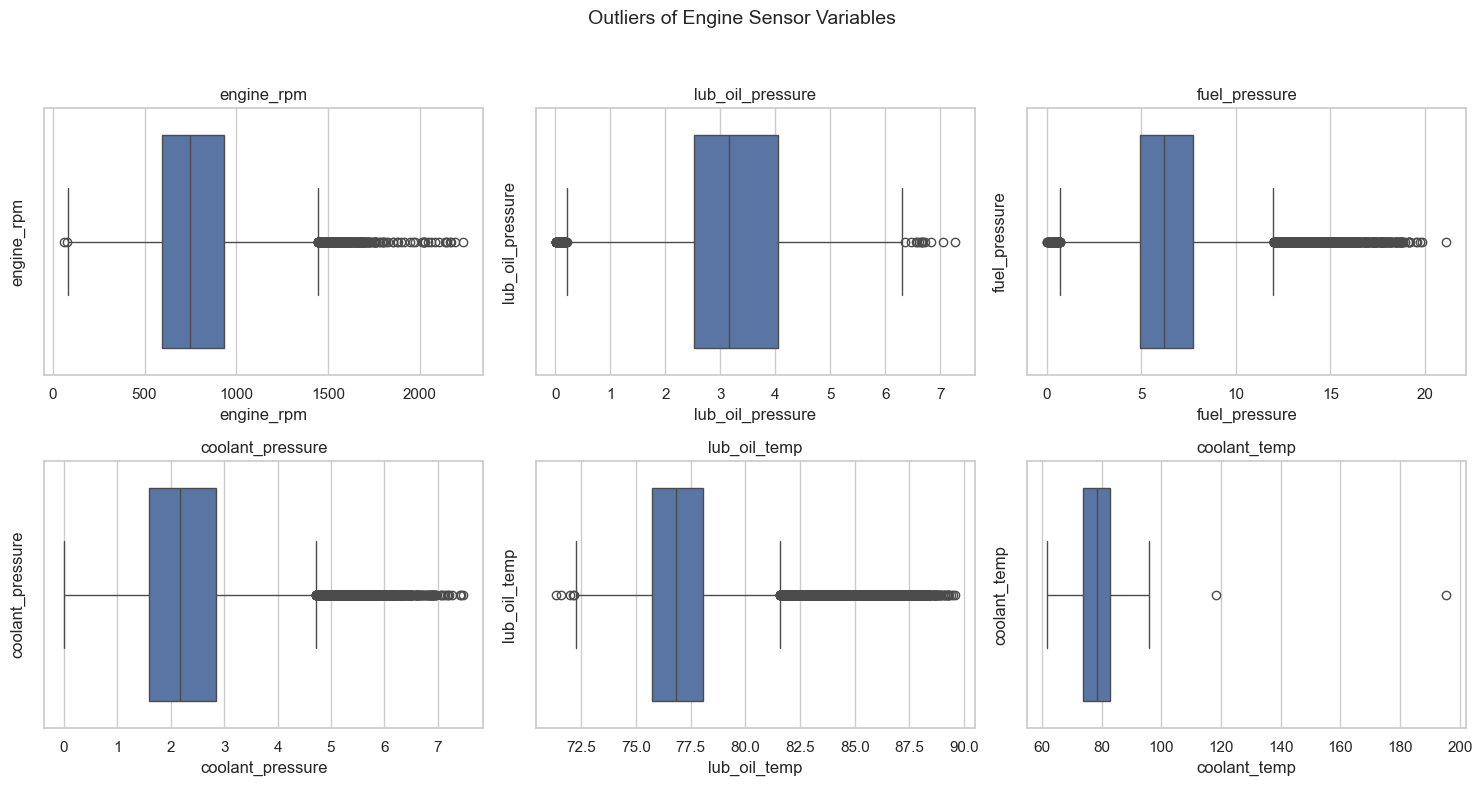

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

sensor_cols = [
    'engine_rpm',
    'lub_oil_pressure',
    'fuel_pressure',
    'coolant_pressure',
    'lub_oil_temp',
    'coolant_temp'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    sns.boxplot(
        x=df[col],
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_ylabel(col)

plt.suptitle("Outliers of Engine Sensor Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../reports/figures/univariate_sensor_outliers.png", dpi=300)
plt.show()

### Distribution of Sensor Variables

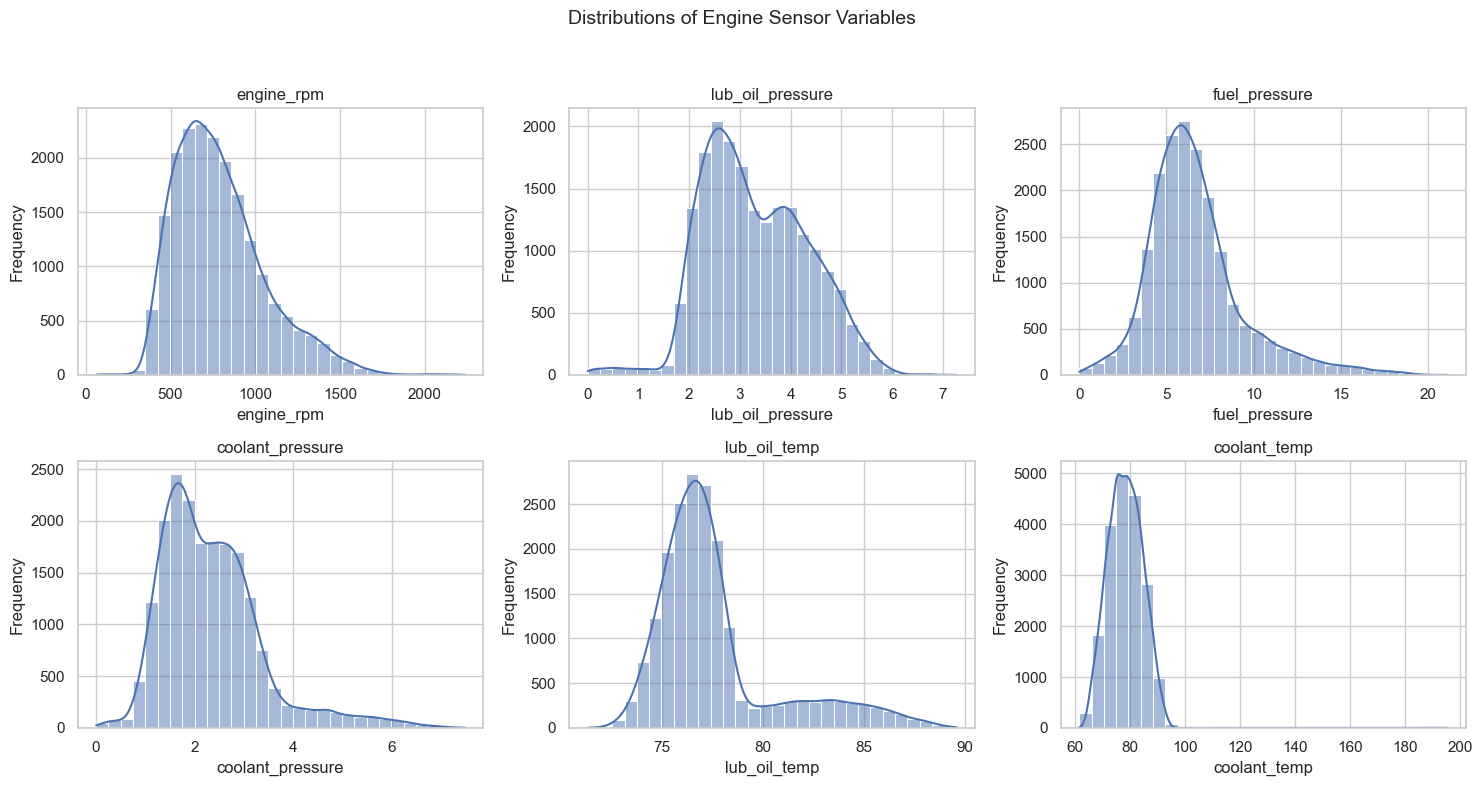

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

sensor_cols = [
    'engine_rpm',
    'lub_oil_pressure',
    'fuel_pressure',
    'coolant_pressure',
    'lub_oil_temp',
    'coolant_temp'
]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    sns.histplot(
        df[col],
        bins=30,
        kde=True,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.suptitle("Distributions of Engine Sensor Variables", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("../reports/figures/univariate_sensor_distributions.png", dpi=300)
plt.show()

Observations

- The coolant temperature distribution is approximately bell-shaped with slight right skew, with most observations concentrated between 70°C and 85°C, representing the normal operating temperature range.
- A clear peak is observed around 75–80°C, indicating stable coolant temperature under standard engine operating conditions.
- The histogram shows a tight concentration of values in the normal range, suggesting effective cooling system regulation for most engines.
- The boxplot reveals the presence of rare but extreme high-temperature outliers, with values exceeding 120°C and one extreme observation close to 190°C.
- The interquartile range is narrow, indicating low variability in coolant temperature during normal engine operation, with anomalies occurring infrequently but at very high magnitudes.


Business Interpretation

- Coolant temperature is a primary indicator of engine thermal stability and cooling system effectiveness.
- The presence of extreme high-temperature outliers is particularly critical, as such temperatures strongly suggest severe overheating events, which can cause catastrophic engine damage.
- These rare but extreme values may correspond to coolant loss, radiator failure, pump malfunction, or prolonged high engine load without adequate heat dissipation.
- Even infrequent overheating incidents can significantly reduce engine lifespan, making coolant temperature a high-priority variable for failure prevention.
- Early detection of abnormal coolant temperature spikes enables immediate maintenance intervention, preventing costly repairs and unplanned breakdowns.



> Due to the presence of rare but extreme overheating events, coolant temperature is expected to be one of the strongest discriminators between normal and failure-prone engine states in the predictive maintenance model.

## Bivariate Analysis

Bivariate analysis examines the relationship between individual sensor variables and the target variable (`engine_condition`).  
The objective is to identify sensors whose behavior differs significantly between normal and failure conditions, which can indicate early warning signals of engine degradation.

###  Sensor vs Engine Condition

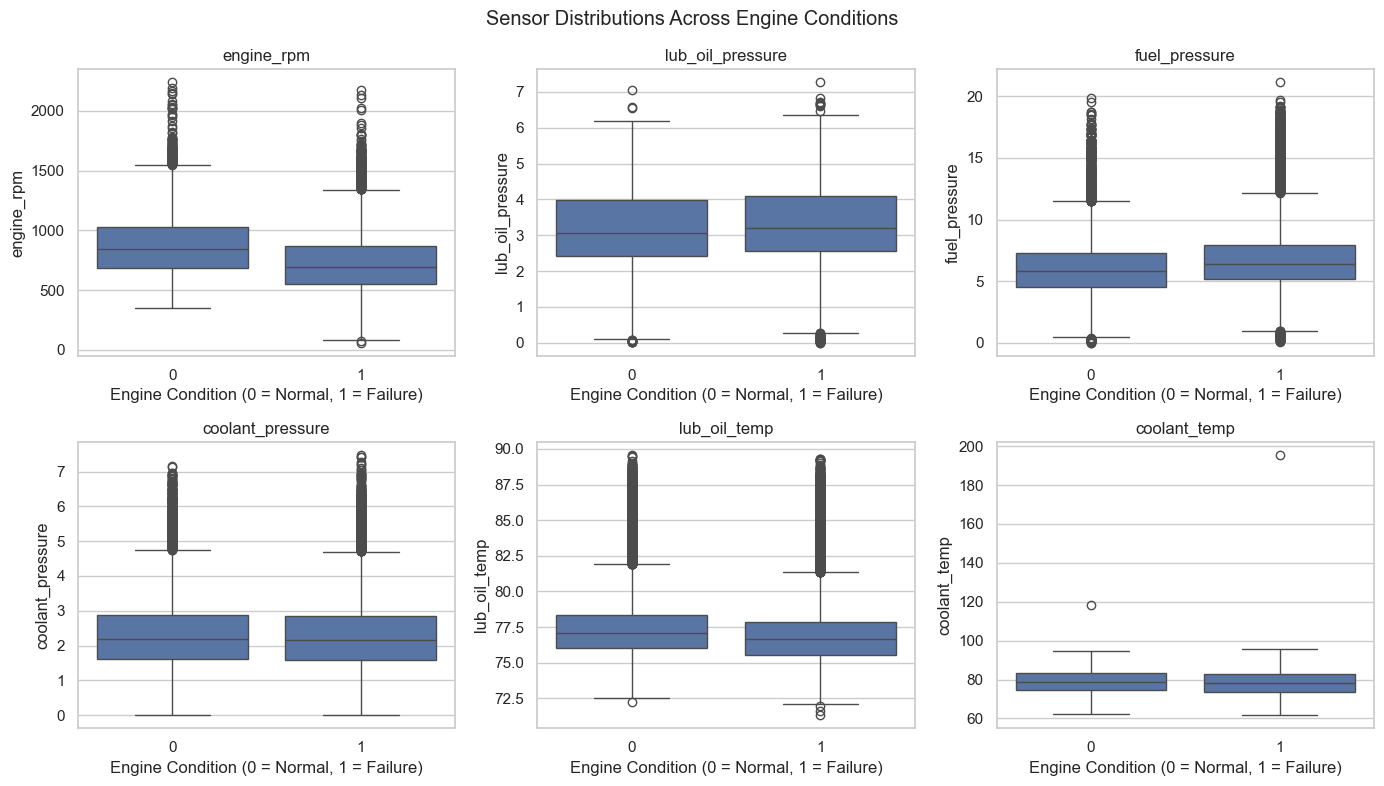

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

sensor_cols = [
    'engine_rpm',
    'lub_oil_pressure',
    'fuel_pressure',
    'coolant_pressure',
    'lub_oil_temp',
    'coolant_temp'
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

for i, col in enumerate(sensor_cols):
    sns.boxplot(
        x='engine_condition',
        y=col,
        data=df,
        ax=axes[i]
    )
    axes[i].set_title(col)
    axes[i].set_xlabel("Engine Condition (0 = Normal, 1 = Failure)")
    axes[i].set_ylabel(col)

plt.suptitle("Sensor Distributions Across Engine Conditions")
plt.tight_layout()
plt.savefig("../reports/figures/bivariate_sensor_vs_target.png", dpi=300)
plt.show()

### Mean Comparison

In [34]:
grouped_stats = (
    df
    .groupby('engine_condition')[sensor_cols]
    .mean()
    .round(2)
)

grouped_stats

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp
engine_condition,,,,,,
0,885.0,3.22,6.24,2.37,78.02,78.80
1,736.3,3.35,6.90,2.32,77.42,78.21


### Bivariate Analysis Observations

- Several sensors show noticeable differences in their central tendency between normal and failure conditions.
- Lubrication oil pressure and coolant-related variables exhibit shifts in distribution prior to failure, indicating potential degradation effects.
- Temperature-related sensors tend to show higher variance in failure cases, suggesting thermal stress as a contributing factor.
- These patterns indicate that the selected sensor variables contain useful signal for predicting engine failure.

## Multivariate Analysis

Multivariate analysis is performed to study relationships among multiple sensor variables simultaneously.  
This analysis helps identify correlated features, redundancy, and structural dependencies that may influence model selection and feature engineering decisions.

### Correlation Matrix & Heatmap

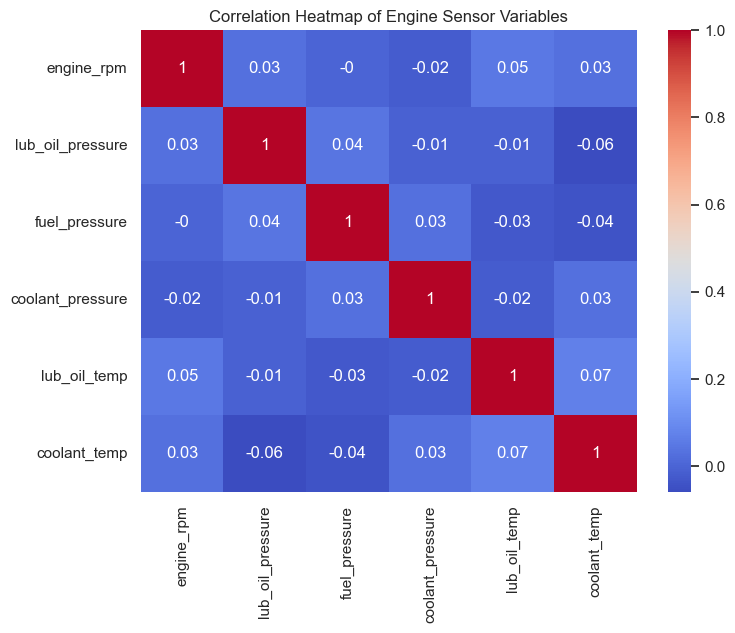

In [35]:
corr_matrix = df[sensor_cols].corr().round(2)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Engine Sensor Variables')
plt.savefig("../reports/figures/correlation_heatmap.png", dpi=300)
plt.show()

### Multivariate Analysis Observations

- Several sensor variables exhibit moderate to strong correlations, particularly among pressure-related and temperature-related features.
- High correlation between certain sensors suggests redundancy, which may not negatively impact tree-based models but could affect linear models.
- The presence of correlated features supports the use of ensemble and tree-based algorithms, which are robust to multicollinearity.

## EDA Insights and Observations

The following key insights were derived from the exploratory data analysis:

- The target variable (`engine_condition`) is imbalanced, with failure events occurring less frequently than normal operation. This indicates that accuracy alone is not a sufficient evaluation metric.
- Multiple sensor variables show clear distributional differences between failure and non-failure cases, confirming the feasibility of predictive modeling.
- Lubrication oil pressure and coolant-related variables appear to be strong indicators of engine health and degradation.
- Temperature sensors exhibit higher variability in failure conditions, suggesting thermal stress as a potential contributor to engine breakdown.
- Several sensor variables are correlated, indicating redundancy in the feature set. This supports the use of tree-based ensemble models that handle multicollinearity effectively.
- Based on these observations, recall-oriented evaluation metrics (such as Recall and F1-score) will be prioritized to minimize missed failure events.

These insights directly inform the data preparation strategy, model selection, and evaluation criteria used in subsequent stages of the project.

## Data Preparation

### Load dataset directly from Hugging Face data space
The following cell loads the dataset **directly from the registered Hugging Face dataset** (no local file). This demonstrates that the data are retrieved from the Hub for reproducibility.

In [36]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(
    "mukherjee78/predictive-maintenance-engine-data",
    data_files="raw_data.csv"
)

df = dataset["train"].to_pandas()
df.head()

,Engine rpm,Lub oil pressure,Fuel pressure,Coolant pressure,lub oil temp,Coolant temp,Engine Condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


In [37]:
df.columns = standardize_column_names(df)

In [38]:
selected_columns = [
    'engine_rpm',
    'lub_oil_pressure',
    'fuel_pressure',
    'coolant_pressure',
    'lub_oil_temp',
    'coolant_temp',
    'engine_condition'
]

df_clean = df[selected_columns].copy()
df_clean.head()

,engine_rpm,lub_oil_pressure,fuel_pressure,coolant_pressure,lub_oil_temp,coolant_temp,engine_condition
0,700,2.493592,11.790927,3.178981,84.144163,81.632187,1
1,876,2.941606,16.193866,2.464504,77.640934,82.445724,0
2,520,2.961746,6.553147,1.064347,77.752266,79.645777,1
3,473,3.707835,19.510172,3.727455,74.129907,71.774629,1
4,619,5.672919,15.738871,2.052251,78.396989,87.000225,0


### Sanity Checks

In [39]:
df_clean.isnull().sum()

engine_rpm          0
lub_oil_pressure    0
fuel_pressure       0
coolant_pressure    0
lub_oil_temp        0
coolant_temp        0
engine_condition    0
dtype: int64

In [40]:
df_clean['engine_condition'].value_counts(normalize=True)

engine_condition
1    0.630509
0    0.369491
Name: proportion, dtype: float64

### Train–Test Split (Stratified)

In [41]:
from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=['engine_condition'])
y = df_clean['engine_condition']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.shape, test_df.shape

((15628, 7), (3907, 7))

### Save Train/Test Locally

In [42]:
train_df.to_csv("../data/processed/train.csv", index=False)
test_df.to_csv("../data/processed/test.csv", index=False)

### Upload Train/Test Back to Hugging Face

In [43]:
from huggingface_hub import HfApi

api = HfApi()

api.upload_file(
    path_or_fileobj="../data/processed/train.csv",
    path_in_repo="train.csv",
    repo_id="mukherjee78/predictive-maintenance-engine-data",
    repo_type="dataset"
)

api.upload_file(
    path_or_fileobj="../data/processed/test.csv",
    path_in_repo="test.csv",
    repo_id="mukherjee78/predictive-maintenance-engine-data",
    repo_type="dataset"
)

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/mukherjee78/predictive-maintenance-engine-data/commit/06888d4a84a13d57b0469a2100c6fedee73cb24f', commit_message='Upload test.csv with huggingface_hub', commit_description='', oid='06888d4a84a13d57b0469a2100c6fedee73cb24f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/mukherjee78/predictive-maintenance-engine-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='mukherjee78/predictive-maintenance-engine-data'), pr_revision=None, pr_num=None)

## Model Building with Experimentation Tracking

### Load Train/Test from Hugging Face

In [44]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset(
    "mukherjee78/predictive-maintenance-engine-data",
    data_files={
        "train": "train.csv",
        "test": "test.csv"
    }
)

train_df = dataset["train"].to_pandas()
test_df = dataset["test"].to_pandas()

X_train = train_df.drop(columns=["engine_condition"])
y_train = train_df["engine_condition"]

X_test = test_df.drop(columns=["engine_condition"])
y_test = test_df["engine_condition"]

X_train.shape, X_test.shape

((15628, 6), (3907, 6))

### Model — Decision Tree

In [45]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
print("Decision Tree fitted.")

Decision Tree fitted.


### Model — Random Forest with Hyperparameter Tuning

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2],
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best params:", grid_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}


### Model — Logistic Regression

Logistic Regression with scaled features as a linear baseline for comparison.

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
print("Logistic Regression fitted.")

Logistic Regression fitted.


### Model — Gradient Boosting with Hyperparameter Tuning

Gradient Boosting with GridSearchCV (recall scoring) for comparison with Random Forest.

In [48]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=42)
gb_param_grid = {
    "n_estimators": [50, 100, 150, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "min_samples_split": [2, 5],
}
gb_search = GridSearchCV(
    estimator=gb,
    param_grid=gb_param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
gb_search.fit(X_train, y_train)
best_gb = gb_search.best_estimator_
print("Best params:", gb_search.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


### Model — XGBoost with Hyperparameter Tuning

XGBoost classifier with GridSearchCV (recall scoring) for comparison with other ensemble models.

In [49]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric="logloss")
xgb_param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.8, 1.0],
}
xgb_search = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring="recall",
    cv=3,
    n_jobs=-1,
    verbose=1,
)
xgb_search.fit(X_train, y_train)
best_xgb = xgb_search.best_estimator_
print("Best params:", xgb_search.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


### Log Tuned Parameters & Results

**Workflow:** Run all model training cells above first, then this cell to log tuned parameters for RF, GB, and XGBoost. After that, run "Evaluate all models" to get test metrics and pick the best by recall.

In [50]:
# Log tuned parameters for all three tuned models (RF, GB, XGBoost)
cols = ["params", "mean_test_score", "rank_test_score"]

experiment_log_rf = pd.DataFrame(grid_search.cv_results_)[cols].sort_values("rank_test_score")
print("Random Forest — top CV results:")
display(experiment_log_rf.head())

experiment_log_gb = pd.DataFrame(gb_search.cv_results_)[cols].sort_values("rank_test_score")
print("Gradient Boosting — top CV results:")
display(experiment_log_gb.head())

experiment_log_xgb = pd.DataFrame(xgb_search.cv_results_)[cols].sort_values("rank_test_score")
print("XGBoost — top CV results:")
display(experiment_log_xgb.head())

Random Forest — top CV results:


,params,mean_test_score,rank_test_score
17,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.896895,1
1,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.896590,2
16,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.896590,3
13,"{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.896083,4
7,"{'max_depth': 5, 'min_samples_leaf': 1, 'min_s...",0.896083,5


Gradient Boosting — top CV results:


,params,mean_test_score,rank_test_score
0,"{'learning_rate': 0.01, 'max_depth': 3, 'min_s...",1.000000,1
4,"{'learning_rate': 0.01, 'max_depth': 3, 'min_s...",1.000000,1
12,"{'learning_rate': 0.01, 'max_depth': 5, 'min_s...",0.989345,3
8,"{'learning_rate': 0.01, 'max_depth': 5, 'min_s...",0.989345,3
20,"{'learning_rate': 0.01, 'max_depth': 7, 'min_s...",0.980922,5


XGBoost — top CV results:


,params,mean_test_score,rank_test_score
1,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.966714,1
0,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.964075,2
6,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.940531,3
7,"{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",0.939314,4
12,"{'learning_rate': 0.01, 'max_depth': 7, 'n_est...",0.930484,5


### Evaluate All Models on Test Data

Evaluate all five models on the test set, then pick the best by recall for confusion matrix and saving.

In [51]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# Predictions and probabilities for all five models (LR uses scaled features)
dt_preds = dt_model.predict(X_test)
dt_probs = dt_model.predict_proba(X_test)[:, 1]

rf_preds = best_rf.predict(X_test)
rf_probs = best_rf.predict_proba(X_test)[:, 1]

lr_preds = lr_model.predict(X_test_scaled)
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

gb_preds = best_gb.predict(X_test)
gb_probs = best_gb.predict_proba(X_test)[:, 1]

xgb_preds = best_xgb.predict(X_test)
xgb_probs = best_xgb.predict_proba(X_test)[:, 1]

# Print report and ROC-AUC for each
for name, preds, probs in [
    ("Decision Tree", dt_preds, dt_probs),
    ("Random Forest", rf_preds, rf_probs),
    ("Logistic Regression", lr_preds, lr_probs),
    ("Gradient Boosting", gb_preds, gb_probs),
    ("XGBoost", xgb_preds, xgb_probs),
]:
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, probs), "\n")

# Build comparison table (five models)
comparison_df = pd.DataFrame({
    "Model": ["Decision Tree", "Random Forest", "Logistic Regression", "Gradient Boosting", "XGBoost"],
    "Precision": [
        precision_score(y_test, dt_preds, zero_division=0),
        precision_score(y_test, rf_preds, zero_division=0),
        precision_score(y_test, lr_preds, zero_division=0),
        precision_score(y_test, gb_preds, zero_division=0),
        precision_score(y_test, xgb_preds, zero_division=0),
    ],
    "Recall": [
        recall_score(y_test, dt_preds, zero_division=0),
        recall_score(y_test, rf_preds, zero_division=0),
        recall_score(y_test, lr_preds, zero_division=0),
        recall_score(y_test, gb_preds, zero_division=0),
        recall_score(y_test, xgb_preds, zero_division=0),
    ],
    "F1 Score": [
        f1_score(y_test, dt_preds, zero_division=0),
        f1_score(y_test, rf_preds, zero_division=0),
        f1_score(y_test, lr_preds, zero_division=0),
        f1_score(y_test, gb_preds, zero_division=0),
        f1_score(y_test, xgb_preds, zero_division=0),
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, dt_probs),
        roc_auc_score(y_test, rf_probs),
        roc_auc_score(y_test, lr_probs),
        roc_auc_score(y_test, gb_probs),
        roc_auc_score(y_test, xgb_probs),
    ],
})

# Pick best by recall for confusion matrix and saving
best_idx = comparison_df["Recall"].idxmax()
best_name = comparison_df.loc[best_idx, "Model"]
models_and_X = [
    (dt_model, X_test),
    (best_rf, X_test),
    (lr_model, X_test_scaled),
    (best_gb, X_test),
    (best_xgb, X_test),
]
best_estimator, X_plot = models_and_X[best_idx]
print("Best model by recall:", best_name)
comparison_df

--- Decision Tree ---
              precision    recall  f1-score   support

           0       0.44      0.44      0.44      1444
           1       0.67      0.68      0.68      2463

    accuracy                           0.59      3907
   macro avg       0.56      0.56      0.56      3907
weighted avg       0.59      0.59      0.59      3907

ROC-AUC: 0.558749548722759 

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.59      0.25      0.35      1444
           1       0.67      0.90      0.77      2463

    accuracy                           0.66      3907
   macro avg       0.63      0.58      0.56      3907
weighted avg       0.64      0.66      0.62      3907

ROC-AUC: 0.699677948316525 

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.58      0.29      0.39      1444
           1       0.68      0.88      0.77      2463

    accuracy                           0.66      390

/Users/siddhartha/Projects/ai/predictive_maintenance/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/siddhartha/Projects/ai/predictive_maintenance/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/siddhartha/Projects/ai/predictive_maintenance/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

,Model,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,0.673519,0.678441,0.675971,0.558750
1,Random Forest,0.672136,0.898092,0.768856,0.699678
2,Logistic Regression,0.678695,0.878197,0.765664,0.691760
3,Gradient Boosting,0.630407,1.000000,0.773312,0.685659
4,XGBoost,0.648788,0.967519,0.776728,0.689626


### Confusion Matrix

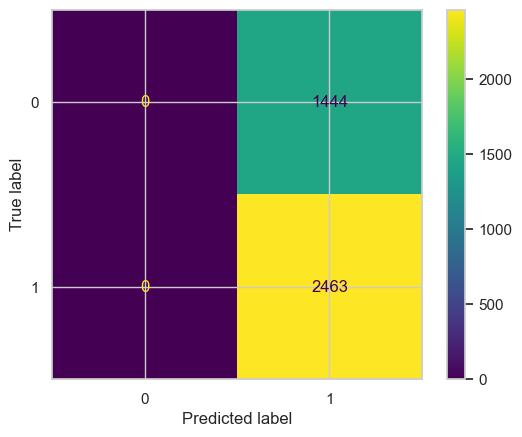

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Use best model and correct feature set (from "Evaluate all" cell; fallback to best_rf if that cell wasn't run)
estimator = best_estimator if 'best_estimator' in globals() else best_rf
X_cm = X_plot if 'X_plot' in globals() else X_test

fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(estimator, X_cm, y_test, ax=ax)
plt.savefig("../reports/figures/confusion_matrix_best_model.png")
plt.show()



### Model Comparison

In [53]:
# comparison_df was built in the "Evaluate all models" cell above
print("Best model by recall:", best_name if 'best_name' in globals() else "— run 'Evaluate all' cell first")
comparison_df

Best model by recall: Gradient Boosting


,Model,Precision,Recall,F1 Score,ROC-AUC
0,Decision Tree,0.673519,0.678441,0.675971,0.558750
1,Random Forest,0.672136,0.898092,0.768856,0.699678
2,Logistic Regression,0.678695,0.878197,0.765664,0.691760
3,Gradient Boosting,0.630407,1.000000,0.773312,0.685659
4,XGBoost,0.648788,0.967519,0.776728,0.689626


### Save Best Model Locally

In [54]:
import joblib

model_path = "../models/best_random_forest.pkl"
joblib.dump(best_rf, model_path)

model_path

'../models/best_random_forest.pkl'

### Register Best Model on Hugging Face Model Hub

In [55]:
from datasets import load_dataset
import pandas as pd


from huggingface_hub import create_repo, upload_file, HfApi

model_rf_repo_id = "mukherjee78/predictive-maintenance-random-forest"

api = HfApi()

create_repo(
    repo_id=model_rf_repo_id,
    repo_type="model",
    private=False,
    exist_ok=True
)

api.upload_file(
    path_or_fileobj="../models/best_random_forest.pkl",
    path_in_repo="best_random_forest.pkl",
    repo_id="mukherjee78/predictive-maintenance-random-forest",
    repo_type="model"
)

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/mukherjee78/predictive-maintenance-random-forest/commit/8b49853c0780cb73c9cfb8691a62a2310a32c35a', commit_message='Upload best_random_forest.pkl with huggingface_hub', commit_description='', oid='8b49853c0780cb73c9cfb8691a62a2310a32c35a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/mukherjee78/predictive-maintenance-random-forest', endpoint='https://huggingface.co', repo_type='model', repo_id='mukherjee78/predictive-maintenance-random-forest'), pr_revision=None, pr_num=None)

## Model Deployment

The trained model is deployed as a Streamlit app on the Hugging Face Space. The following components are defined in the repository:

- **Dockerfile:** Defines the container for the app. Key configurations:
  - Base image: `python:3.11-slim`
  - System dependencies: `build-essential`, `curl` (for healthcheck)
  - Copy `requirements.txt` and install Python dependencies
  - Copy `app.py`
  - Expose port **7860** (Hugging Face Docker Spaces default; proxy forwards to this port so the app loads.)
  - Healthcheck: `curl -f http://localhost:7860/_stcore/health`
  - CMD: `streamlit run app.py --server.port=7860 --server.address=0.0.0.0 --server.headless=true`

- **Load model from Hugging Face Model Hub:** The app loads the saved model from the Hugging Face model hub (e.g. `mukherjee78/predictive-maintenance-random-forest`). If a local model file exists, it uses that first; otherwise it downloads via `hf_hub_download`.

- **Inputs into a dataframe:** The app collects the six sensor inputs (engine RPM, lub oil pressure, fuel pressure, coolant pressure, lub oil temp, coolant temp) and saves them into a pandas DataFrame before calling `model.predict()` and `model.predict_proba()`.

- **Dependencies file:** `requirements.txt` lists all packages required for deployment (e.g. streamlit, pandas, scikit-learn, joblib, huggingface_hub).

- **Hosting script:** `scripts/deploy.py` pushes all deployment files (app.py, requirements.txt, Dockerfile) to the Hugging Face Space so the Space can build and run the app. It uses `HfApi().upload_file()` for each file and `create_repo(..., space_sdk="docker")` for the Space.

## Automated GitHub Actions Workflow

An end-to-end ML and deployment pipeline is defined in the repository:

- **File:** `.github/workflows/pipeline.yml` (in the GitHub repo)

- **Steps executed by the workflow:**
  1. **Data preparation:** Checkout repo, set up Python, install dependencies, authenticate with Hugging Face, run `scripts/data_preparation.py` (load from HF, clean, split, save locally, upload train/test back to HF), upload processed-data artifact.
  2. **Model training:** Run `scripts/model_training.py` (load train/test from HF, tune model, evaluate, save model and metrics, register best model on the Hugging Face model hub), upload model and reports artifacts.
  3. **Deployment:** Run `scripts/deploy.py` to push app.py, requirements.txt, and Dockerfile to the Hugging Face Space.

- **Automation:** The workflow runs on every **push to the main branch** and can also be triggered manually via **workflow_dispatch**. Pushing code updates to main automatically runs the full pipeline and updates the Space.

## Actionable Insights and Recommendations

## Output Evaluation (Screenshots)

The following screenshots and links satisfy the **Output Evaluation** rubric: GitHub (repository link, folder structure, executed workflow) and Streamlit on Hugging Face (Space link, app screenshot).

**Repository:** [predictive_maintenance](https://github.com/siddmkrj/predictive_maintenance)
**Hugging Face Space:** [predictive-maintenance-app](https://huggingface.co/spaces/mukherjee78/predictive-maintenance-app)

### 1. GitHub — Repository folder structure

*Screenshot: GitHub repo root showing folder structure (e.g. `data/`, `notebooks/`, `reports/`, `scripts/`, `app.py`, `Dockerfile`, `.github/`, etc.).*

![GitHub folder structure](https://raw.githubusercontent.com/siddmkrj/predictive_maintenance/main/screenshots/github_folder_structure.png)

### 2. GitHub — Executed workflow

*Screenshot: GitHub Actions tab showing a completed run of "Predictive Maintenance ML Pipeline" with all three jobs green (Data preparation, Model training, Deploy to HF Spaces).*

![GitHub Actions workflow](https://raw.githubusercontent.com/siddmkrj/predictive_maintenance/main/screenshots/github_workflow_executed.png)

### 3. Hugging Face Space — Streamlit app

*Screenshot: The live Streamlit app on the HF Space (form visible and, if possible, a prediction result after clicking "Predict Engine Condition").*

![Streamlit app on Hugging Face](https://raw.githubusercontent.com/siddmkrj/predictive_maintenance/main/screenshots/hf_space_streamlit_app.png)

**Key takeaways for the business:**

- **Use the deployed app** (Streamlit on Hugging Face Space) to flag engines that may need maintenance based on current sensor readings. Integrate it into operational dashboards or run it on demand for spot checks.

- **Prioritize recall over precision** when interpreting alerts: the model is tuned to reduce missed failures. Some false positives are acceptable to avoid missing real failures.

- **Monitor key sensors** (e.g. lubrication oil pressure, coolant pressure and temperature) in real time; EDA showed these are strong indicators of engine condition and degradation.

- **Retrain periodically** with new sensor and failure data, then re-register the best model on the Hugging Face model hub and redeploy so the app stays up to date.

- **Document and review** any recurring misclassifications (false positives/negatives) to refine features, thresholds, or maintenance procedures.